### Custom ML model to identify local similarities ("links") with sequence profiles

Let $$X \in \{0,1\}^{B\times N\times 6 \times T \times 21}$$ be a batch of **one-hot encoded input translated sequences**,
where $B$ is `batch_size`, $N$ is the number of genomes and $T$ is the `tile_size` (in aa).
The 6 is here the number of translated frames in order (0,+),(1,+),(2,+),(0,-),(1,-),(2,-).
The 22 is here the size of the considered amino acid alphabet.


In [1]:
import numpy as np
import tensorflow as tf
import logomaker
from time import time
from IPython.display import Audio

import importlib
import sequtils as su
print(importlib.reload(su))
import seq
print(importlib.reload(seq))

Matplotlib is building the font cache; this may take a moment.


<module 'sequtils' from '/home/matthis/genomegraph/learn_specific_profiles/sequtils.py'>
<module 'seq' from '/home/matthis/genomegraph/learn_specific_profiles/seq.py'>


### Create random genomes as toy data 

In [18]:
N = 8            # number of genomes
tile_size = 334  # tile size measured in amino acids
# A tile is a consecutive subsequence of _one_ contig/scaffold/chromosome.
# Tiles should be about gene-sized.

#genome_sizes = [[210,100], [30,220,150], [230,110,120,90], [180]] # in nucleotides
#insertPatterns = ["ATGATGATG", "CCCCCCCCCCCC"]
#genomes = seq.getRandomGenomes(N, genome_sizes, insertPatterns, mutationProb=0.2, verbose=True)

genome_sizes = [[1000]] * 8
                # in nucleotides
insertPatterns = ["ATGGCAAGAATTCAATCTACTGCAAATAAAGAA",
                 ] 
#repeatPatterns = ['AGAGAACCTGAAGCTACTGCTGAACCTGAAAGA']
genomes = seq.getRandomGenomes(N, genome_sizes, insertPatterns,
                               #repeatPatterns,
                               mutationProb=0.1, verbose=True)

Pattern ATGGCAAGAATTCAATCTACTGCAAATAAAGAA translates to  ['MARIQSTANKE', 'WQEFNLLQIK', 'GKNSIYCK*R', 'FFICSRLNSCH', 'SLFAVD*ILA', 'LYLQ*IEFLP']
  mutated to ATGGCAAGAATTCAATCTACTGCAAACAAGGAA and inserted in genome 0 contig 0 at position 945
  mutated to ATGGCAAGAATTCAATCTACTGCAAAAAAAGAA and inserted in genome 1 contig 0 at position 685
  mutated to ATGGCAAGAATTCAATCTACCGCAAATAAAGAA and inserted in genome 2 contig 0 at position 650
  mutated to ATGGCAAGCATTCACTCTACAGCAAATAAAGAC and inserted in genome 3 contig 0 at position 158
  mutated to ATGGCCAGAATTCAATCTACTGCAAATAAAGAA and inserted in genome 4 contig 0 at position 677
  mutated to ATGGCAAGGATCCAATCTACTGCAAAAAACGAA and inserted in genome 5 contig 0 at position 218
  mutated to ATGGCAAGGATTCACTCTACTGCAAACAAAGAA and inserted in genome 6 contig 0 at position 12
  mutated to ATGGCAAGAATTCAATCAACAGCAAATAAAGAC and inserted in genome 7 contig 0 at position 526


In [19]:
desiredPatternAA = []
for pattern in insertPatterns:
    desiredPatternAA.extend(su.six_frame_translation(pattern))
    
repeatPatternAA = []
for pattern in repeatPatterns:
    repeatPatternAA.extend(su.six_frame_translation(pattern))
    
print("Desired:", desiredPatternAA)
print("Repeat:", repeatPatternAA)

Desired: ['MARIQSTANKE', 'WQEFNLLQIK', 'GKNSIYCK*R', 'FFICSRLNSCH', 'SLFAVD*ILA', 'LYLQ*IEFLP']
Repeat: ['REPEATAEPER', 'ENLKLLLNLK', 'RT*SYC*T*K', 'SFRFSSSFRFS', 'LSGSAVASGS', 'FQVQQ*LQVL']


In [4]:
#enomes

In [20]:
# background distribution observed in the data 
Q = seq.backGroundAAFreqs(genomes, True)

# uniform background distribution appears to be rather better
#Q = np.ones(21, dtype=np.float32)/21

background freqs:  15968.0 *
C 0.0316
K 0.0325
E 0.0304
W 0.0172
T 0.0626
G 0.0614
Y 0.0335
A 0.0551
I 0.0514
N 0.0340
V 0.0624
H 0.0320
S 0.0922
D 0.0321
F 0.0318
M 0.0177
R 0.0872
L 0.0948
P 0.0616
Q 0.0318
* 0.0467


#### Read in the genome

In [21]:
batch_size = 1  # number of tile per batch, constrained by RAM and gradient descent performance

X = seq.getNextBatch(genomes, batch_size, tile_size, verbose=False)
X.shape

(1, 8, 6, 334, 21)

In [22]:
def plotLogo(P, idxarray = None, pScores = None, max_print=5):
    """
    max_print  print up to this many logos
    """
    dfs = su.makeDFs(P.numpy())
    for i in range(min(U,max_print)):
        j = idxarray[i] if idxarray is not None else i
        profile_df = dfs[j]
        logo = logomaker.Logo(profile_df, vpad=.1, width=1)
        logo.style_xticks(anchor=0, spacing=1, rotation=45)
        logo.ax.set_ylabel('information (bits)')
        logo.ax.set_title(f"Profile {j}" + (f" score={pScores[j]:.1f}") if pScores is not None else "")

## TensorFlow Model
Let $$P = (P[w,c,u]) \in [0,1]^{k \times 21 \times U}$$
be a collection of $U$ amino acid **profiles**, each of length $k$.
Let $$ Q = (Q[c]) \in [0,1]^{21}$$ be a background amino acid distribution.

Both are normalized distributions:
$$ \sum_c P[w,c,u] = \sum_c Q[c] = 1 \qquad \forall u,w.$$

Define the scores tensor 
$$ S \in \mathbb{R}^ {B\times N \times U}$$
by
$$ S[b,g,u] = \max_{f=0}^5 \max_{v=0}^{T-k} \sum_{w=0}^{k-1} \sum_{c=0}^{20} X[b,g,f,v+w,c] \cdot \ln \frac {P[w,c,u]}{Q[c]}.$$

For a given batch $S[b,g,u]$ is the maximal score that the $u$-th profile scores in the $b$-th tile of genome $g$.
It can be computed using a **one dimensional convolution** and max pooling.

Define the intermediate variables:

$R \in [0,1]^{k \times 21 \times U}$ by 
$$ R[w,c,u] := \ln \frac {P[w,c,u]}{Q[c]}.$$

$Z \in \mathbb{R}^{B\times N \times 6 \times T-k-1\times U}$ by
$$Z[b,g,f,v,u] := \sum_{w=0}^{k-1} \sum_{c=0}^{20} X[b,g,f,v+w,c] \cdot R[w,c,u].$$

**Losses:**
Only the best score counts for each frame and tile. Sum them up.
$$L_1 = - \sum_{b=1}^B \sum_{g=1}^G \sum_{u=1}^U S[b,g,u]$$ 

In [23]:
U = 100 # number of profiles to train
k = 11 # length of profiles

In [35]:
class SpecificProfile(tf.keras.Model):
    def __init__(self, k, alphabet_size, units, Q, **kwargs):
        super().__init__(**kwargs)
        # P_logit_init = tf.random.normal([k, alphabet_size, units], stddev=.5, dtype=tf.float32, seed=1)
        
        #np.random.seed(1)
        
        P_logit_init = np.random.normal(scale=.5, size=[k, alphabet_size, units]).astype('float32')
        #P_logit_init[4,19,:] = 5 # Q
        #P_logit_init[5,12,:] = 5 # S
        #P_logit_init[6,4,:] = 5 # T
        if False: # to test whether the right pattern has low loss
            P_logit_init = -100 *np.ones([k, 21, units], dtype=np.float32)
            P_logit_init[0,15,:] = 5 # M
            P_logit_init[1,7,:] = 5 # A
            P_logit_init[2,16,:] = 5 # R
            P_logit_init[3,8,:] = 5 # I
            P_logit_init[4,19,:] = 5 # Q
            P_logit_init[5,12,:] = 5 # S
            P_logit_init[6,4,:] = 5 # T
            P_logit_init[7,7,:] = 5 # A
            P_logit_init[8,9,:] = 5 # N
            P_logit_init[9,1,:] = 5 # K
            P_logit_init[10,2,:] = 5 # E

        self.P_logit = tf.Variable(P_logit_init, trainable=True, name="P_logit") 
        self.Q = Q
        self.k = k
        self.alphabet_size = alphabet_size
        self.units = units

    def getP(self):
        # P1_logit = -1000 * tf.ones([self.k, 1, self.units])
        # P2_logit = tf.stack([P1_logit, self.P_logit], axis=1)
        P = tf.nn.softmax(self.P_logit, axis=1, name="P")
        return P
    
    def call(self, X):
        P = self.getP()
        Q1 = tf.expand_dims(self.Q,0)
        Q2 = tf.expand_dims(Q1,-1)
        # Limit the odds-ratio, to prevent problemt with log(0).
        # Very bad matches of profiles are irrelevant anyways.
        ratio = tf.maximum(P/Q2, 1e-6)
        R = tf.math.log(ratio)

        X1 = tf.expand_dims(X,-1) # 1 input channel
        R1 = tf.expand_dims(R,-2) # 1 input channel
        Z1 = tf.nn.conv2d(X1, R1, strides=1,
                         padding='VALID', data_format="NHWC", name="Z")
        Z = tf.squeeze(Z1, 4) # remove input channel dimension

        S = tf.reduce_max(Z, axis=[2,3])
        return S, R

    # custom loss
    def loss(self, S):
        # overall fit of patterns
        L1 = -tf.reduce_sum(S)
        # L1 = -tf.reduce_sum(tf.reduce_max(S, axis=[0,2]))
        
        # homogeneity along pattern
        P = self.getP()
        H = -tf.reduce_sum(tf.math.multiply(P, tf.math.log(P)), axis=1) # entropy
        # standard deviation of entropies
        VH = tf.math.reduce_std(H, axis=0) # variance for each profile along site axis
        L2 = tf.reduce_mean(VH)
        
        # homogeneity between genomes
        # ignore the best score per genome, so that rather others are improved
        L3 = tf.reduce_sum(tf.reduce_max(S, axis=1)) # cancels out the best occurence from L1
        
        # other ideas: 
        # - std deviation of scores of different genomes
        L4 = tf.reduce_sum(tf.math.reduce_std(tf.reduce_max(S, axis=0), axis=0))
        # - minimum score of any genome
        
        #return (L1+L3)/N + 50*L2, L2, L4 # + 100*L2 # (L1 + L3)/N #+ 100*L2
        return L1, L2, L4 # + 100*L2

    @tf.function()
    def train_step(self, X):
        with tf.GradientTape() as tape:
            S, _ = self.call(X)
            L, _, _ = self.loss(S)

        grad = tape.gradient(L, self.P_logit)
        self.opt.apply_gradients([(grad, self.P_logit)])

    def train(self, X, epochs=1000, verbose=True):
        self.opt = tf.keras.optimizers.Adam(learning_rate=.1) # large learning rate is much faster
        for i in range(epochs):
            self.train_step(X)
            if verbose and (i%(100) == 0 or i==epochs-1):
                S, R = self(X)
                L, _, _ = self.loss(S)
                print(f"epoch {i:>5} loss={L.numpy():.4f}" +
                      " max R: {:.3f}".format(tf.reduce_max(R).numpy()) +
                      " min R: {:.3f}".format((tf.reduce_min(R).numpy())))

In [25]:
tf.keras.backend.clear_session() # avoid memory cluttering by remains of old models

In [26]:
# build and randomly initialize profile model
specProModel = SpecificProfile(k, su.aa_alphabet_size, U, Q)

In [27]:
if False:
    P_init = specProModel.getP()
    plotLogo(P_init)

### Training

In [138]:
start = time()
specProModel.train(X, epochs=500)
end = time()
print(f"time: {end-start:.2f}")
#Audio("/home/mario/audio/fertig.mp3", autoplay=True)

epoch     0 loss=-6798.3184 max R: 3.387 min R: -2.887
epoch   100 loss=-15798.1660 max R: 5.285 min R: -7.896
epoch   200 loss=-15834.4268 max R: 5.291 min R: -8.563
epoch   300 loss=-15846.4170 max R: 5.293 min R: -9.027
epoch   400 loss=-15851.9883 max R: 5.294 min R: -9.387
epoch   499 loss=-15855.0605 max R: 5.295 min R: -9.680
time: 4.33


In [139]:
S, R = specProModel(X)
L1, L2, L4 = specProModel.loss(S)
pScores = tf.reduce_sum(tf.reduce_max(S,axis=0), axis=0).numpy()
print("pScores", pScores)
np.argsort(pScores)
print ("loss=", L1.numpy(), "\tL2=", L2.numpy(), 
       "\tL4=", L4.numpy(), "\nS=", S.numpy())
#print ("R", R.numpy())

pScores [160.47095 159.78253 151.98643 152.44617 149.72256 157.88843 151.82838
 157.32458 155.57323 165.07465 163.06248 157.49626 147.93878 157.02023
 157.36122 154.86523 155.4306  157.96083 159.03502 153.06996 150.60162
 170.42633 163.98    169.47003 155.59697 158.40776 157.71649 151.06258
 159.24907 155.07732 152.46933 157.62302 156.48904 160.75818 151.19333
 163.64105 255.76227 157.51562 152.57306 154.61838 158.91797 149.56061
 150.13962 150.23686 160.32455 148.69276 155.03288 160.3269  154.54749
 163.14993 154.20735 151.44766 158.68465 154.2569  160.0678  146.91475
 167.79117 151.09927 157.00217 157.70671 158.30501 153.01093 159.29857
 156.66736 162.69615 160.24738 165.68724 148.42525 160.38658 157.40503
 151.79703 153.86621 159.56218 157.8988  154.45555 153.30774 150.41492
 156.97284 160.77206 153.40115 150.9876  172.2497  160.9979  156.1106
 228.24533 155.0184  161.02005 157.48904 146.16663 160.83723 165.04291
 165.85516 148.42944 153.3081  150.89194 163.30823 153.64343 155.55293

### Visualize resulting profiles as sequence logos

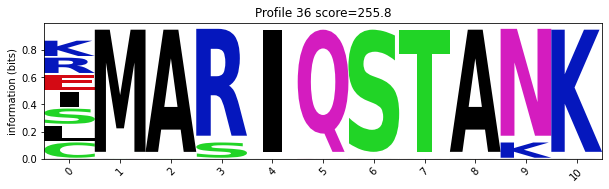

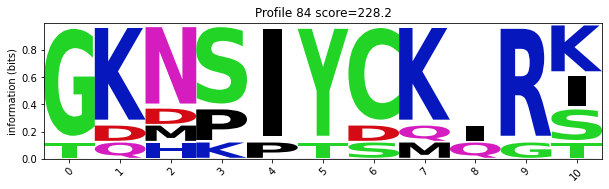

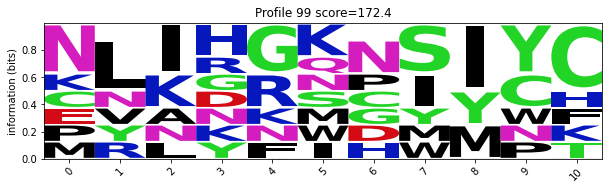

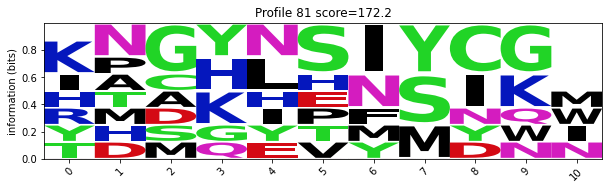

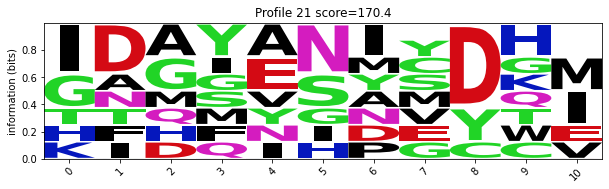

In [184]:
P = specProModel.getP()
plotLogo(P=P, idxarray = np.argsort(-pScores), pScores=pScores, max_print=5)
# should be similar to one of ['MARIQSTANKE', 'WQEFNLLQIK', 'GKNSIYCK*R', 'FFICSRLNSCH', 'SLFAVD*ILA', 'LYLQ*IEFLP']
# Repeats: ['REPEATAEPER', 'ENLKLLLNLK', 'RT*SYC*T*K', 'SFRFSSSFRFS', 'LSGSAVASGS', 'FQVQQ*LQVL']

In [141]:
# dataset = tf.data.Dataset.from_tensor_slices([X])

---

Idea: 
* convert profiles into aa-sequences (translate max. values into aa at each position)
* align (or perfect match?) sequences against the 6 possible pattern translations and the insert translations
* alignment scores give an idea of how good the profiles are -> allows multiple training runs to account for randomness, evaluate how good the profiles usually are (+ variance)

In [28]:
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

In [29]:
def runTraining():
    tf.keras.backend.clear_session() # avoid memory cluttering by remains of old models
    
    # build and randomly initialize profile model
    specProModel = SpecificProfile(k, su.aa_alphabet_size, U, Q)
    
    #start = time()
    specProModel.train(X, epochs=500, verbose=False)
    #end = time()
    #print(f"time: {end-start:.2f}")
    
    #S, R = specProModel(X)
    #L1, L2, L4 = specProModel.loss(S)
    #pScores = tf.reduce_sum(tf.reduce_max(S,axis=0), axis=0).numpy()
    #print("pScores", pScores)
    #np.argsort(pScores)
    #print ("loss=", L1.numpy(), "\tL2=", L2.numpy(), 
    #       "\tL4=", L4.numpy(), "\nS=", S.numpy())
    
    P = specProModel.getP()
    
    return P

In [30]:
def aaFromProfiles(P):
    profiles_aa = []
    for pidx in range(P.shape[2]):
        pmat = P[:,:,pidx]
        profiles_aa.append(su.to_aa_seq(pmat))

    return profiles_aa

In [31]:
def getBestAlignments(profiles, patterns, scoreThreshold = int(k/2)):
    scores = []
    alignments = []
    best_profiles = []
    for profile in profiles:
        pscores = []
        palignments = []
        for pattern in patterns:
            als = pairwise2.align.localxd(profile, pattern, openA=-1000, extendA=-1000, openB=-1000, extendB=-1000)
            s = [al.score for al in als]
            if len(s) > 0:
                pscores.append(np.argmax(s))
                palignments.append(als[np.argmax(s)])

        best_al = palignments[np.argmax(pscores)]
        if best_al.score >= scoreThreshold:
            scores.append(best_al.score)
            alignments.append(best_al)
            best_profiles.append(profile)

    if len(scores) > 0:
        sortedIdx = np.argsort([-s for s in scores])
        scores = [scores[i] for i in sortedIdx]
        alignments = [alignments[i] for i in sortedIdx]
        best_profiles = [best_profiles[i] for i in sortedIdx]
    
    return scores, alignments, best_profiles

In [32]:
for i in range(20):
    P = runTraining()
    profiles = aaFromProfiles(P)
    print("Run", i)
    print("Desired profiles:")
    patternScores, patternAlignments, patternProfiles = getBestAlignments(profiles, desiredPatternAA)
    for i in range(len(patternScores)):
            print(patternProfiles[i])
            print(format_alignment(*(patternAlignments[i])))
            
    #print("Undesired profiles:")
    #repeatScores, repeatAlignments, repeatProfiles = getBestAlignments(profiles, repeatPatternAA)
    #for i in range(len(repeatScores)):
    #        print(repeatProfiles[i])
    #        print(format_alignment(*(repeatAlignments[i])))
            
    print("")
    print("-----")
    print("")

Run 0
Desired profiles:

-----

Run 1
Desired profiles:

-----

Run 2
Desired profiles:

-----

Run 3
Desired profiles:

-----

Run 4
Desired profiles:

-----

Run 5
Desired profiles:

-----

Run 6
Desired profiles:

-----

Run 7
Desired profiles:

-----

Run 8
Desired profiles:

-----

Run 9
Desired profiles:

-----

Run 10
Desired profiles:

-----

Run 11
Desired profiles:

-----

Run 12
Desired profiles:

-----

Run 13
Desired profiles:

-----

Run 14
Desired profiles:

-----

Run 15
Desired profiles:
GRIKYYDNKEN
2 RIKYYDNKE
  ||....|||
3 RIQSTANKE
  Score=5


-----

Run 16
Desired profiles:

-----

Run 17
Desired profiles:
IWTTANKDQEH
1 IWTTANK
  |..||||
4 IQSTANK
  Score=5


-----

Run 18
Desired profiles:

-----

Run 19
Desired profiles:

-----



In [38]:
np.random.seed()
P = runTraining()
profiles = aaFromProfiles(P)
print("Desired profiles:")
patternScores, patternAlignments, patternProfiles = getBestAlignments(profiles, desiredPatternAA, scoreThreshold=4)
for i in range(len(patternScores)):
        print(patternProfiles[i])
        print(format_alignment(*(patternAlignments[i])))

Desired profiles:
